# Minimal crowd simulation example

This guide explains how to run multiple simulations with the **CrowdMechanics** library and how to manage their outputs. It has been tested on macOS Sequoia 15.6.1 and Ubuntu 24.04.3 LTS, provided that in what follows the shared library relative path `../../../../src/mechanical_layer/build/libCrowdMechanics` is written with the correct extension: `.dylib` on macOS and `.so` on Ubuntu.

The scenario we are replicating is the **forward propagation of a push through a row of people** close to a wall (experience from [Feldmann S., Adrian J., 2023](https://doi.org/10.1016/j.ssci.2023.106173)).

---

## 1. Export crowd configuration files

1. Open the [**Streamlit app**](https://lemons.streamlit.app/).
2. Go to the **Crowd** tab.
3. Click **"Initialise your own crowd"**.
4. In the sidebar at the bottom, click **"Export crowd as XML config files"**.
5. Download the XML files and save them in an appropriate location.

---

## 2. Set the working environment

Create two folders in the project directory `static` and `dynamic`. Place the just downloaded files (from the Streamlit app) in the respective folders:
  - Move `Agents.xml`, `Geometry.xml`, and `Materials.xml` into the `static` folder.
  - Move `AgentDynamics.xml` into the `dynamic` folder.

Create a `Parameters.xml` file in the current folder location. Use the following template (replace the paths with the actual folder locations):

```xml
<?xml version="1.0" encoding="utf-8"?>
<Parameters>
    <Directories Static="./static/" Dynamic="./dynamic/"/>
    <Times TimeStep="0.05" TimeStepMechanical="2e-6"/>
</Parameters>
```

**Directory structure example:**
```
.
├── Parameters.xml
├── static/
|   ├── Agents.xml
│   ├── Geometry.xml
│   └── Materials.xml
└── dynamic/
    └── AgentDynamics.xml
```

---

## 3. Build the C++ project

Navigate to the root of the `mechanical_layer` directory and build the project:

```bash
cmake -H. -Bbuild -DBUILD_SHARED_LIBS=ON
cmake --build build
```

---

## 4. Run a series of simulations

Execute the Python code below, modifying it as needed for your experiments.
Simulation results are automatically saved in the `outputXML/` directory.
Each output file is named as follows:
```
AgentDynamics output t=TIME_VALUE.xml
```
Here, `TIME_VALUE` represents the specific simulation time or identifier for that run.

First, we import the recorded external force data corresponding to the initial push applied to the leftmost agent in the row, and then construct an interpolation function so that it can be used as the propulsion-force input for the mechanical layer (all other agents have a self-propulsion force equal to $\mathbf{0}$):

In [1]:
import xml.etree.ElementTree as ET
from pathlib import Path

import pandas as pd
from scipy.interpolate import interp1d

# === Import of external force data ===
dataPath = Path("../../../../data/tutorial_mechanical_layer/push_Feldmann/Wed_03_m_wiW_row4_14_w_s_b_p_n_u")
df = pd.read_csv(
    dataPath / "external_force_per_mass.txt",
    sep=r"\s+",
    header=0,
    names=["time [s]", "force per mass [N/m]"],
)

# === Read mass of agent with Id 0 from XML configuration ===
XMLtree = ET.parse("static/Agents.xml")
agentsTree = XMLtree.getroot()

mass_agent_0 = 0.0
for agent in agentsTree:
    if int(agent.attrib["Id"]) == 0:
        mass_agent_0 = float(agent.attrib["Mass"])
        break

print(f"Mass of agent 0: {mass_agent_0} kg\n")

# === Build interpolator for the external force on agent 0 ===
_push_agent0_interp = interp1d(
    df["time [s]"].values,
    df["force per mass [N/m]"].values * mass_agent_0,  # Multiply force per unit mass by mass to obtain the total force on agent 0.
    kind="linear",
    fill_value=0.0,  # zero force outside the sampled time range
)

Mass of agent 0: 89.0 kg



Now, run the mechanical layer:

In [2]:
import ctypes
import os
import xml.etree.ElementTree as ET
from pathlib import Path
from shutil import copyfile

# === Simulation Parameters ===
dt = 0.05  # Time step for the decisional layer (matches "TimeStep" in Parameters.xml)
Ndt = 90  # How many dt will be performed in total

# === Paths Setup ===
outputPath = Path("outputXML")  # Directory to store output XML files
inputPath = Path("inputXML")  # Directory to store input XML files
outputPath.mkdir(parents=True, exist_ok=True)  # Create directories if they don't exist
inputPath.mkdir(parents=True, exist_ok=True)
for file in list(outputPath.glob("*.xml")) + list(inputPath.glob("*.xml")):
    os.remove(file) # Clean old XML files

# === Loading the External Mechanics Library ===
# Adjust filename for OS (.so for Linux, .dylib for macOS)
Clibrary = ctypes.CDLL("../../../../src/mechanical_layer/build/libCrowdMechanics.dylib")

agentDynamicsFilename = "AgentDynamics.xml"

# Prepare the list of XML files that will be passed to the DLL/shared library
files = [
    b"Parameters.xml",
    b"Materials.xml",
    b"Geometry.xml",
    b"Agents.xml",
    agentDynamicsFilename.encode("ascii"),  # Convert filename to bytes (required by ctypes)
]
nFiles = len(files)  # Number of configuration files to be passed
filesInput = (ctypes.c_char_p * nFiles)()  # Create a ctypes array of string pointers
filesInput[:] = files  # Populate array with the XML file names

# === Main Simulation Loop ===
for t in range(Ndt):
    if t % 10 == 0:
        print("Looping the Crowd mechanics engine - t=%.2fs..." % (t * dt))

    # 1. Save the current AgentDynamics file as input for this step (can be used for analysis later)
    copyfile(
        "dynamic/" + agentDynamicsFilename,
        str(inputPath) + rf"/AgentDynamics input t={t * dt:.2f}.xml",
    )

    # 2. Call the external mechanics engine, passing in the list of required XML files
    if Clibrary.CrowdMechanics(filesInput) != 0:
        print("Crowd mechanics engine failed!")
        exit(0)

    # 3. Save the updated AgentDynamics output to results folder (can be used for analysis later)
    copyfile(
        "dynamic/" + agentDynamicsFilename,
        str(outputPath) + rf"/AgentDynamics output t={(t + 1) * dt:.2f}.xml",
    )

    # 4. If the simulation produced an AgentInteractions.xml file, save that as well (optional output)
    try:
        copyfile(
            "dynamic/AgentInteractions.xml",
            str(outputPath) + rf"/AgentInteractions t={(t + 1) * dt:.2f}.xml",
        )
    except FileNotFoundError:
        # If the AgentInteractions file does not exist, skip copying
        pass

    # === Decision/Controller Layer for Next Step ===
    # Read the output AgentDynamics XML as input for the next run.
    # This is where you (or another program) can set new forces/moments for each agent for the next simulation step.
    XMLtree = ET.parse("dynamic/" + agentDynamicsFilename)
    agentsTree = XMLtree.getroot()

    # -- Assign forces/moments to each agent --
    for agent in agentsTree:
        # Create new <Dynamics> tag for the agent (as the output file doesn't have it)
        dynamicsItem = ET.SubElement(agent, "Dynamics")

        # Assign force, and moment from the data to the agent with Id=0 otherwise zero
        if int(agent.attrib["Id"]) == 0:
            dynamicsItem.attrib["Fp"] = f"{_push_agent0_interp(t * dt):.4f},{0.0:.2f}"
        else:
            dynamicsItem.attrib["Fp"] = f"{0.0:.2f},{0.0:.2f}"
        dynamicsItem.attrib["Mp"] = f"{0.0:.2f}"

    # Write the modified XML back, to be used in the next iteration
    XMLtree.write("dynamic/" + agentDynamicsFilename)
    # ================================================

# After all simulation steps are complete, print a final message.
print(f"Loop terminated at t={Ndt * dt:.2f}s!")

Looping the Crowd mechanics engine - t=0.00s...
Looping the Crowd mechanics engine - t=0.50s...
Looping the Crowd mechanics engine - t=1.00s...
Looping the Crowd mechanics engine - t=1.50s...
Looping the Crowd mechanics engine - t=2.00s...
Looping the Crowd mechanics engine - t=2.50s...
Looping the Crowd mechanics engine - t=3.00s...
Looping the Crowd mechanics engine - t=3.50s...
Looping the Crowd mechanics engine - t=4.00s...
Loop terminated at t=4.50s!


For precise explanations, read the `Mechanical layer` tutorial.

---

## 5. Export to ChAOS

The output files can be easily converted into `.csv` format, ready for direct import into [ChAOS](https://project.inria.fr/crowdscience/project/ocsr/chaos/). ChAOS uses these CSV files containing time, x, and y coordinates for each agent, to visualize and animate trajectories for further analysis and video generation.

To get started, from the root directory, create a Python virtual environment and install the required dependencies with [uv](https://docs.astral.sh/uv/):

```bash
python -m pip install --upgrade pip
pip install uv
uv sync
```

Then run the following Python script:

In [ ]:
import os
from pathlib import Path

from configuration.backup import xml_to_Chaos  # For converting XML to Chaos format

filenameCSV = "all_trajectories.csv"  # Name of the final CSV file we’ll generate
cwd = Path(os.path.abspath(""))  # Current working directory
PathXML = cwd / "inputXML"  # Folder path where the XML files are located
PathCSV = cwd / "inputCSV"  # Folder path where CSV files will be saved
PathCSV.mkdir(parents=True, exist_ok=True)  # Create directories if it doesn't exist
for file in PathCSV.glob("*.csv"):
    os.remove(file) # clean old files

# Convert XML files to a single summarized CSV
xml_to_Chaos.export_XML_to_CSV(PathCSV, PathXML)

# Convert CSV to ChAOS format
xml_to_Chaos.export_CSV_to_CHAOS(PathCSV, dt)

---

## 6. Export scene snapshots as PNG images

A plot of the scene can be generated from each input or output file under `PNG` format using the Python wrapper. 

First, load the experimental and simulated trajectories so they can be included in the plot:

In [4]:
import pandas as pd

# Load experimental data
with open(dataPath / "measured_head_trajectories.pkl", "rb") as f:
    df_data = pd.read_pickle(f)

# Preprocess experimental data
df_data[["x", "y"]] -= df_data[["x", "y"]].iloc[0]  # shift so first agent starts at (0, 0)
df_data[["x", "y"]] *= 100.0  # m -> cm
df_data = df_data[df_data["time"] <= Ndt * dt]  # keep data within simulated time window
df_data[["x", "y"]] = df_data[["y", "x"]] * [-1.0, 1.0]  # rotate to match simulation coordinate frame: (x, y) -> (-y, x)

# Load simulated trajectories
df_simulated = pd.read_csv(PathCSV / "all_trajectories.csv")
df_simulated[["x", "y"]] *= 100.0  # m -> cm

Then plot the full scene for each time step, including the experimental and simulated trajectories:

In [5]:
import cmcrameri as cram
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import configuration.backup.dict_to_xml_and_reverse as fun_xml  # For converting XML to dictionary and vice versa
from configuration.models.crowd import create_agents_from_dynamic_static_geometry_parameters  # For creating agents based on XML data
from streamlit_app.plot import plot  # For plotting crowd data

# === Prepare the folders ===
# Define the paths to the folders you'll use
outputPath = Path("outputXML")
staticPath = Path("static")
plotsPath = Path("plots")
plotsPath.mkdir(parents=True, exist_ok=True)  # Create plots directory if it doesn't exist

# Remove any old '.png' and '.pdf' files in the plots directory
for file in list(plotsPath.glob("*.png")) + list(plotsPath.glob("*.pdf")):
    os.remove(file)

# === Load static XML files ===
# Read the Agents.xml file as a string and convert it to a dictionary
with open(staticPath / "Agents.xml", encoding="utf-8") as f:
    crowd_xml = f.read()
static_dict = fun_xml.static_xml_to_dict(crowd_xml)

# Read the Geometry.xml file as a string and convert it to a dictionary
with open(staticPath / "Geometry.xml", encoding="utf-8") as f:
    geometry_xml = f.read()
geometry_dict = fun_xml.geometry_xml_to_dict(geometry_xml)

# === Loop over time steps ===
for t in range(Ndt):
    current_time = (t + 1) * dt

    # Check if the dynamics file exists; if not, skip to the next time step
    dynamics_file = outputPath / f"AgentDynamics output t={current_time:.2f}.xml"
    if not dynamics_file.exists():
        print(f"Warning: {dynamics_file} not found, skipping.")
        continue

    # === Read and process the dynamics XML file ===
    # Read the current dynamics XML file as a string and convert it to a dictionary
    with open(dynamics_file, encoding="utf-8") as f:
        dynamic_xml = f.read()
    dynamic_dict = fun_xml.dynamic_xml_to_dict(dynamic_xml)

    # Create a crowd object using the configuration files data
    crowd = create_agents_from_dynamic_static_geometry_parameters(
        static_dict=static_dict,
        dynamic_dict=dynamic_dict,
        geometry_dict=geometry_dict,
    )

    # Plot the crowd
    fig, ax = plot.display_crowd2D(crowd)

    # ==== Plot Trajectories (data and simulated) ====
    # Base color per agent, taken from the same colormap as their 2Dshape
    areas = [agent.shapes2D.get_area() for agent in crowd.agents]
    norm = Normalize(vmin=min(areas), vmax=max(areas))
    agent_colors = {agent_id: cram.cm.hawaii(norm(agent.shapes2D.get_area())) for agent_id, agent in enumerate(crowd.agents)}

    # Plot measured and simulated trajectories with a darker version of the 2Dshape color
    for agent_id, (_, data_group) in enumerate(df_data.groupby("id", observed=True)):
        traj_color = plot.darken(agent_colors.get(agent_id, "k"), factor=0.8)
        # Experimental trajectory (rotated to align with simulation coordinates)
        ax.plot(data_group["x"], data_group["y"], linestyle="--", color=traj_color, linewidth=2.5, zorder=5)
        # Mark the start of the trajectory with a black dot
        ax.plot(data_group["x"].iloc[0], data_group["y"].iloc[0], marker="o", color="black", markersize=5, zorder=7)
        # Simulated trajectory for the same agent, ordered in time
        sim_group = df_simulated.loc[df_simulated["ID"] == agent_id].sort_values("t")
        ax.plot(sim_group["x"], sim_group["y"], linestyle="-", color=traj_color, linewidth=2.5, zorder=6)
    # =================================================

    plt.savefig(plotsPath / rf"crowd2D_t={t:d}.png", dpi=300, format="png")
    plt.savefig(plotsPath / rf"crowd2D_t={t:d}.pdf", format="pdf")
    plt.close()

---

## 7. Export to a movie with FFMPEG

Finally, combine all the `PNG` images into a video using [FFmpeg](https://ffmpeg.org/). Be sure to update the `FFmpeg` path in the script to match your system. The resulting video will be saved in `.mov` format.

In [6]:
import subprocess

ffmpeg = "/Users/oscardufour/ffmpeg_bin/ffmpeg"  # To be adjusted to your ffmpeg binary location
movie_name = "pushing_scenario"
cwd = Path(os.path.abspath(""))
moviesPath = cwd / "movies"
moviesPath.mkdir(parents=True, exist_ok=True)
framerate = int(1.0 / dt)

# 0. Clean the movies folder from old files
for file in list(moviesPath.glob("*.mp4")) + list(moviesPath.glob("*.mov")):
    os.remove(file)

# 1. Create an MP4 movie from PNG images in the plots folder
cmd1 = f"{ffmpeg} -framerate {framerate} -i {plotsPath}/crowd2D_t=%d.png {moviesPath}/{movie_name}.mp4 -loglevel quiet"
subprocess.Popen(cmd1.split()).communicate()

# 2. Convert the MP4 to MOV for compatibility
cmd2 = f"{ffmpeg} -i {moviesPath}/{movie_name}.mp4 -pix_fmt yuv420p {moviesPath}/{movie_name}.mov -loglevel quiet"
subprocess.Popen(cmd2.split()).communicate()

# 3. Remove the intermediate MP4 file
cmd3 = f"rm {moviesPath}/{movie_name}.mp4"
subprocess.Popen(cmd3.split()).communicate()

(None, None)

Here are several snapshots of the resulting video (dotted lines: measured head trajectories, solid lines: simulation):

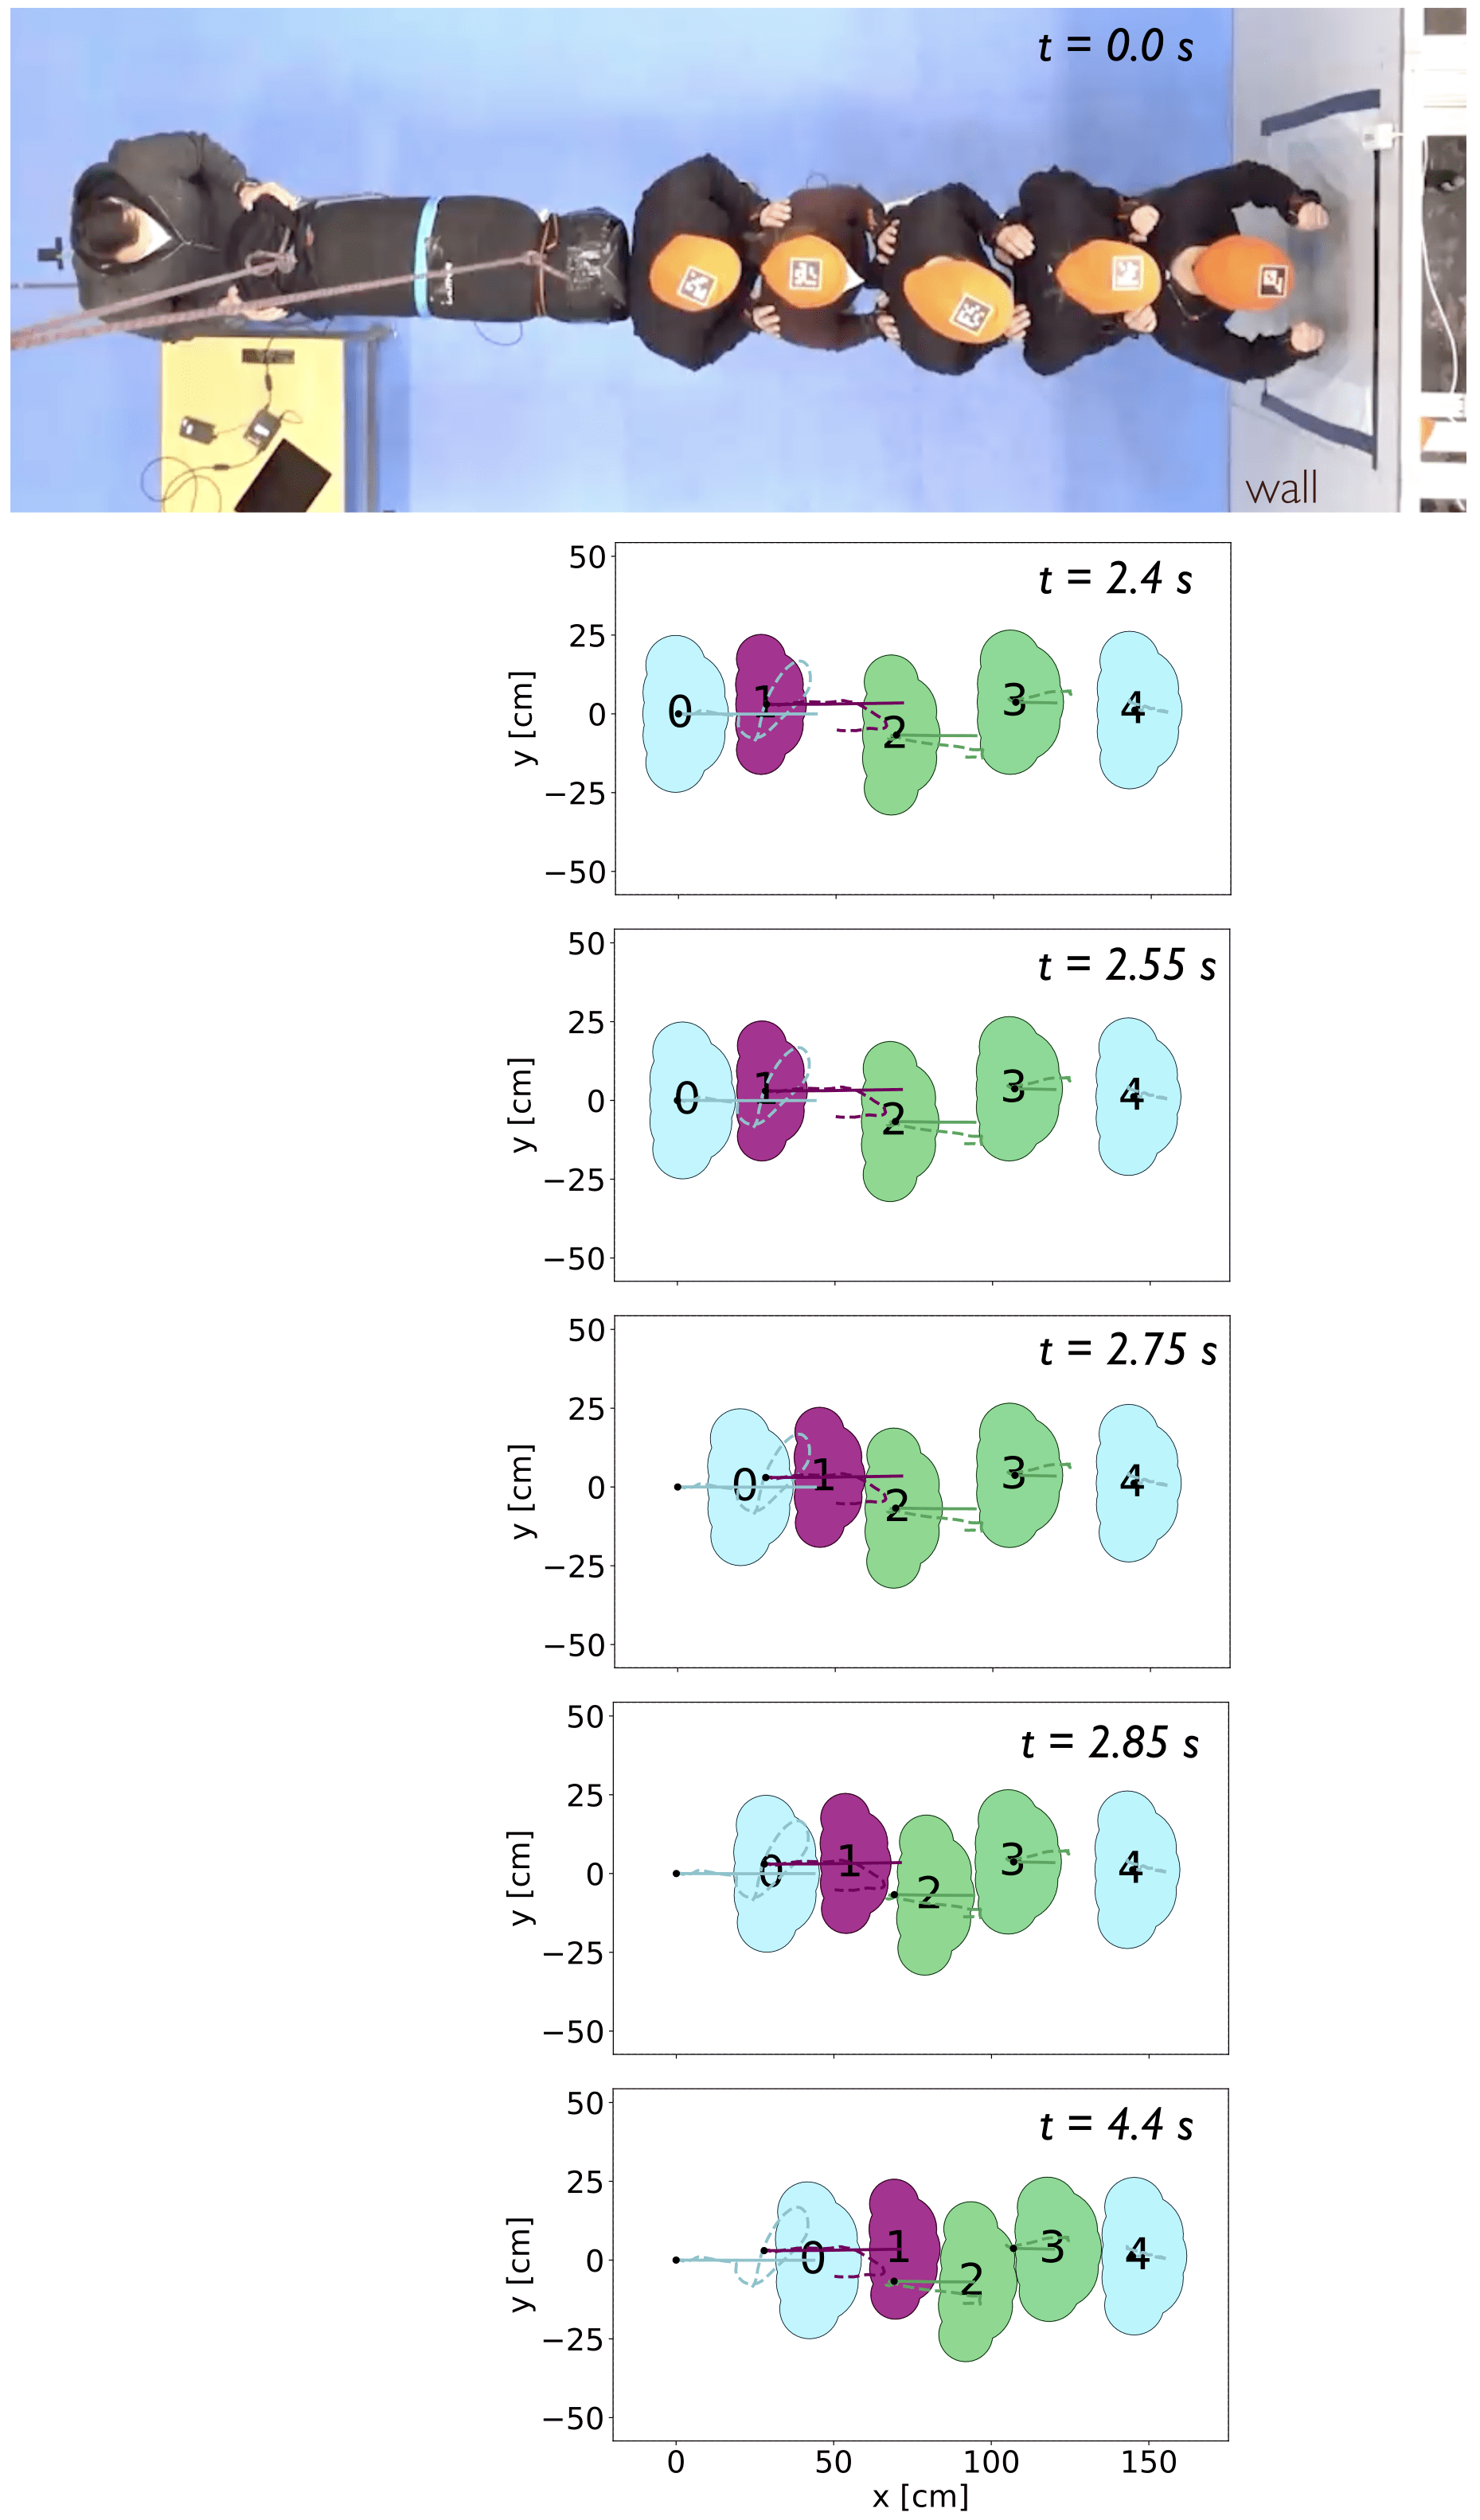

In [7]:
# This cell has a hide-input tag
from IPython.display import Image, display

img_path = Path("../../../../data/images/practical_case_push_close_to_wall.png").resolve()
display(Image(filename=str(img_path), width=450, alt="An example of a crowd simulation."))

For additional examples, other tutorial scenarios are available in the `tutorials/mechanical_layer` directory of the project.